In [52]:
## General Imports

import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
poly,
ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

## Lab Specific Imports
from pygam import (s as s_gam,
l as l_gam,
f as f_gam,
LinearGAM,
LogisticGAM)
from ISLP.transforms import (BSpline,
NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
degrees_of_freedom,
plot as plot_gam,
anova as anova_gam)

## sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### Recreate Figure 7.1

In [22]:
## load wage data
wage = load_data('Wage')

# isolate variables
y = wage['wage']
age = wage['age']

display(wage)

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


In [23]:
## Note the difference between using raw and orthogonal polynomials
## with raw=True, we return the same results as OLS with I(var**degree)

poly_age = MS([poly('age', degree=4, raw=True)]).fit(wage)

M = sm.OLS(y, poly_age.transform(wage)).fit()
display(summarize(M))

## Here, using orthogonal polynomials like in the book
poly_age = MS([poly('age', degree=4)]).fit(wage)

M = sm.OLS(y, poly_age.transform(wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,-184.154200,60.040000,-3.067,0.002
"poly(age, degree=4, raw=True)[0]",21.245500,5.887000,3.609,0.000
"poly(age, degree=4, raw=True)[1]",-0.563900,0.206000,-2.736,0.006
"poly(age, degree=4, raw=True)[2]",0.006800,0.003000,2.221,0.026
"poly(age, degree=4, raw=True)[3]",-0.000032,0.000016,-1.952,0.051


,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [24]:
## Using statsmodels with raw polynomials

linear_model = ols(f'wage ~ age + I(age**2) + I(age**3) + I(age**3) + I(age**4)', data=wage).fit()
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Mon, 20 May 2024   Prob (F-statistic):           2.77e-57
Time:                        10:33:23   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -184.1542     60.040     -3.067      

In [25]:
## Create the following using a sklearn Pipeline
## I'm not performing a train test split, just practicing the syntax in a machine learning setting
## PolynomialFeatures in sklearn uses raw polynomials, as demonstrated by the coeffients 

# Define the pipeline
pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=4)),  # You can change the degree if needed
    ('linear_regression', LinearRegression())
])

pipeline.fit(age.to_numpy().reshape(-1,1), y)

print(pipeline['linear_regression'].coef_)

[ 0.00000000e+00  2.12455205e+01 -5.63859312e-01  6.81068771e-03
 -3.20383037e-05]


In [26]:
## Create a grid of values for age at which we want predictions

age_grid = np.linspace(age.min(),
age.max(),
100)
age_df = pd.DataFrame({'age': age_grid})


In [27]:
## We want to plot and add the fit from the fourth degree polynomial
## Defining a function that we will reuse throughout the lab

## Function that produces a fitted curve as well as 95% confidence bands
## We will use the basis arguement to plot different transforms in future uses
def plot_wage_fit(age_df, basis, title):
    X = basis.transform(wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(age,
                y,
                facecolor='gray',
                alpha=0.5
                )
    for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['b','r--','r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)
    
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('wage', fontsize=20);

    return ax

<AxesSubplot: title={'center': 'Degree-4 Polynomial'}, xlabel='Age', ylabel='wage'>

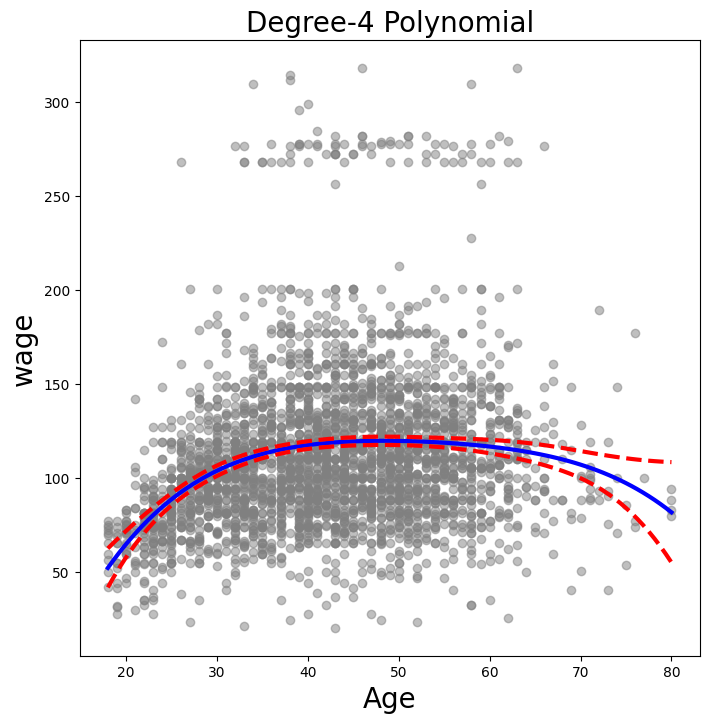

In [28]:
plot_wage_fit(age_df, poly_age, 'Degree-4 Polynomial')

## Deciding on the degree of polynomial to use

- Can perform hypothesis tests.
    - We fit a series of models from one to 5 degree polynomials:
        - Attempt to determine the simplest model that sufficiently describes the relationship between age and wage
        - Using an ANOVA test

In [29]:
models = [MS([poly('age', degree=d)]) for d in range(1, 6)]
Xs = [model.fit_transform(wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


- This ANOVA is telling us that as we add more predictors (variance) we are getting a more flexible fit. Comparing the models, it's clear that the quadratic model is better than the linear, as demonstrated by it's exteremly low p-value
- The cubic model is also significant when compared to the quadratic
- However, anything higher than cubic results in a p-value just above our threshold of 0.05, meaning a Cubic or quadratic fit is probably sufficient

## Use of Orthogonal Polynomials

- Because we are using orthogonal polynomials, the coefficients in that case represent the clear effect (not mixed like with raw) on the response. As a result, the p-values associated with our regression are the same as with anova_lm()

## Classification
- Now we wish to recreate the right side of figure 7.1
    - This aims to predict whether an individual earns more than $250k a year

In [35]:
## We will fit a polynomial logistic regression model
## Must first create the reponse vector

X = poly_age.transform(wage)
high_earn = wage['wage'] > 250

glm_model = sm.GLM(high_earn, X, family=sm.families.Binomial())

glm_results = glm_model.fit()

print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -350.61
Date:                Mon, 20 May 2024   Deviance:                       701.22
Time:                        10:41:38   Pearson chi2:                 3.70e+03
No. Iterations:                    10   Pseudo R-squ. (CS):           0.009724
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                 -4

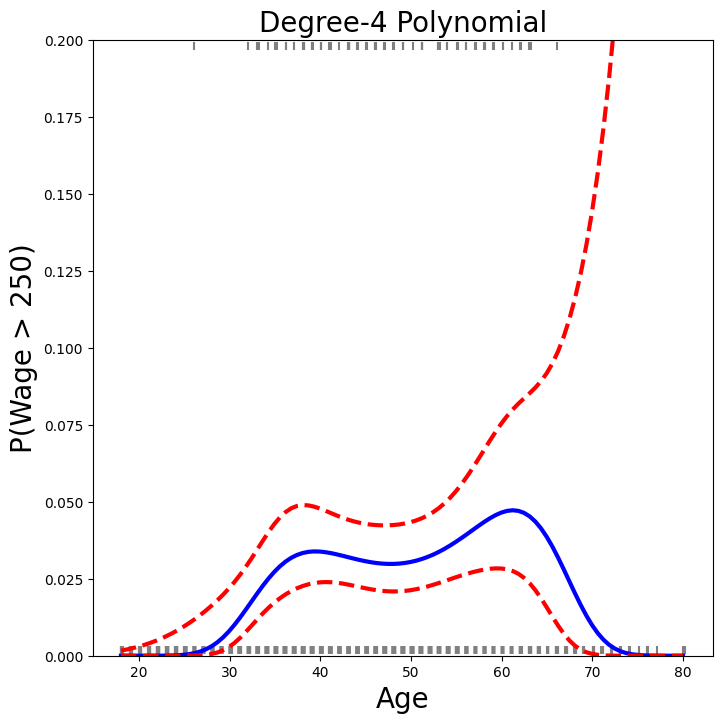

In [38]:
## We can also make predictions with the get_prediction() method

newX = poly_age.transform(age_df)
preds = glm_results.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

## And plot
fig, ax = subplots(figsize=(8,8))
rng = np.random.default_rng(0)
ax.scatter(age +
0.2 * rng.uniform(size=y.shape[0]),
np.where(high_earn, 0.198, 0.002),
fc='gray',
marker='|')
for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['b','r--','r--']):
    ax.plot(age_df.values, val, ls, linewidth=3)
    ax.set_title('Degree-4 Polynomial', fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylim([0,0.2])
    ax.set_ylabel('P(Wage > 250)', fontsize=20)

## Step Functions

In [55]:
## We can also fit a step function to this data to discretize age based on quantiles
## Note that this is to predict wage, not the classification as seen above 
cut_age = pd.qcut(age, 4)
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0
